In [1]:
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage,OdaLightCurve
from oda_api.data_products import BinaryData
import os
from astropy.io import fits
import numpy as np
from numpy import sqrt,exp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
source_name='NGC 2110'
ra=88.047400
dec=-7.456247
radius=15.
radius_jemx=5.
Tstart='2003-03-16T00:00:00'
Tstop='2011-04-06T23:59:59'
host='https://www.astro.unige.ch/cdci/astrooda/dispatch-data'
time_bin=100
E1_keV=20.
E2_keV=40.
E1_keV_jemx=3.
E2_keV_jemx=20.

rebin=10

In [3]:
disp=DispatcherAPI(host=host)

In [4]:
import requests
url="https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/"
def queryxtime(**args):
    params=Tstart+'/'+Tstop+'?&ra='+str(ra)+'&dec='+str(dec)+'&radius='+str(radius)+'&min_good_isgri=1000'
    print(url+params)
    return requests.get(url+params).json()
def queryxtime_jemx1(**args):
    params=Tstart+'/'+Tstop+'?&ra='+str(ra)+'&dec='+str(dec)+'&radius='+str(radius_jemx)+'&min_good_jemx1=1000'
    print(url+params)
    return requests.get(url+params).json()
def queryxtime_jemx2(**args):
    params=Tstart+'/'+Tstop+'?&ra='+str(ra)+'&dec='+str(dec)+'&radius='+str(radius_jemx)+'&min_good_jemx2=1000'
    print(url+params)
    return requests.get(url+params).json()



In [6]:
scwlist=queryxtime()
m=len(scwlist)
pointings_osa10=[]
pointings_osa11=[]
for i in range(m):
    if scwlist[i][-2:]=='10':
        if(int(scwlist[i][:4])<1626):
            pointings_osa10.append(scwlist[i]+'.001')
        else:
            pointings_osa11.append(scwlist[i]+'.001')
m_osa10=len(pointings_osa10)
m_osa11=len(pointings_osa11)
print(pointings_osa10)
print(pointings_osa11)

https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/2003-03-16T00:00:00/2011-04-06T23:59:59?&ra=88.0474&dec=-7.456247&radius=15.0&min_good_isgri=1000
['005100550010.001', '005100560010.001', '006300070010.001', '006300080010.001', '006300090010.001', '023400250010.001', '023400260010.001', '025000140010.001', '025000150010.001', '028600040010.001', '028600050010.001', '028600060010.001', '029200040010.001', '029200050010.001', '030800070010.001', '037200160010.001', '037200170010.001', '041200210010.001', '041200220010.001', '042000180010.001', '042000190010.001', '042800660010.001', '043600020010.001', '043600030010.001', '043600040010.001', '048300030010.001', '048300040010.001', '048300050010.001', '048300060010.001', '048300070010.001', '048300080010.001', '048300090010.001', '048300100010.001', '048300130010.001', '048300140010.001', '048300150010.001', '048300160010.001', '048300170010.001', '048300180010.001', '048300190010.001', '048300250

In [7]:
scw_lists_osa10=[]
scw_lists_osa11=[]
count=0
scw_string=''
for i in range(m_osa10):
    if count<50:
        scw_string=scw_string+str(pointings_osa10[i])+','
        count+=1
    else:
        scw_lists_osa10.append(scw_string[:-1])
        count=1
        scw_string=str(pointings_osa10[i])+','
scw_lists_osa10.append(scw_string[:-1])
print(len(scw_lists_osa10))
count=0
scw_string=''
for i in range(m_osa11):
    if count<50:
        scw_string=scw_string+str(pointings_osa11[i])+','
        count+=1
    else:
        scw_lists_osa11.append(scw_string[:-1])
        count=1
        scw_string=str(pointings_osa11[i])+','
scw_lists_osa11.append(scw_string[:-1])
print(len(scw_lists_osa11))



18
1


In [8]:
data=disp.get_product(instrument='isgri',
                      product='isgri_image',
                      scw_list=scw_lists_osa10[0],
                      E1_keV=E1_keV,
                      E2_keV=E2_keV,
                      osa_version='OSA10.2',
                      RA=ra,
                      DEC=dec,
                      detection_threshold=5,
                      product_type='Real')

005100550010.001,005100560010.001,006300070010.001,006300080010.001,006300090010.001,023400250010.001,023400260010.001,025000140010.001,025000150010.001,028600040010.001,028600050010.001,028600060010.001,029200040010.001,029200050010.001,030800070010.001,037200160010.001,037200170010.001,041200210010.001,041200220010.001,042000180010.001,042000190010.001,042800660010.001,043600020010.001,043600030010.001,043600040010.001,048300030010.001,048300040010.001,048300050010.001,048300060010.001,048300070010.001,048300080010.001,048300090010.001,048300100010.001,048300130010.001,048300140010.001,048300150010.001,048300160010.001,048300170010.001,048300180010.001,048300190010.001,048300250010.001,048300260010.001,048300270010.001,048300280010.001,048300340010.001,048300350010.001,048300360010.001,048300370010.001,048300380010.001,048300390010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 005100550010.001,005100560010.

In [9]:
data.dispatcher_catalog_1.table

meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str10,float64,float64,float64,int64,int64,int64,float64
5,Ark 120,8.21435260772705,79.06550598144531,-0.16832852363586426,-32768,2,0,0.0002800000074785203
7,H 0614+091,25.714115142822266,94.27820587158203,9.146207809448242,-32768,2,0,0.0002800000074785203
25,NGC 2110,12.564316749572754,88.08074188232422,-7.4416399002075195,-32768,2,0,0.0002800000074785203


In [10]:
api_cat=data.dispatcher_catalog_1.get_api_dictionary()

In [11]:
spectrum_results=[]
for i in range(len(scw_lists_osa10)):
    print(i,pointings_osa10[i])
    data=disp.get_product(instrument='isgri',
                        product='isgri_spectrum',
                        scw_list=scw_lists_osa10[i],
                        query_type='Real',
                        osa_version='OSA10.2',
                        RA=ra,
                        DEC=dec,
                        product_type='Real',
                        selected_catalog=api_cat)
    spectrum_results.append(data)

0 005100550010.001
005100550010.001,005100560010.001,006300070010.001,006300080010.001,006300090010.001,023400250010.001,023400260010.001,025000140010.001,025000150010.001,028600040010.001,028600050010.001,028600060010.001,029200040010.001,029200050010.001,030800070010.001,037200160010.001,037200170010.001,041200210010.001,041200220010.001,042000180010.001,042000190010.001,042800660010.001,043600020010.001,043600030010.001,043600040010.001,048300030010.001,048300040010.001,048300050010.001,048300060010.001,048300070010.001,048300080010.001,048300090010.001,048300100010.001,048300130010.001,048300140010.001,048300150010.001,048300160010.001,048300170010.001,048300180010.001,048300190010.001,048300250010.001,048300260010.001,048300270010.001,048300280010.001,048300340010.001,048300350010.001,048300360010.001,048300370010.001,048300380010.001,048300390010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 00510055001

the job has been submitted on the remote server
 / the job is working remotely, please wait status=done - job_id=-2811638118117047318 7318 

query done succesfully!
3 006300080010.001
053800040010.001,053800050010.001,053800060010.001,053800070010.001,053800130010.001,053800140010.001,053800150010.001,053800160010.001,053800170010.001,053800220010.001,053800230010.001,053800240010.001,053800250010.001,053800260010.001,053800270010.001,053800280010.001,053800310010.001,053800320010.001,053800330010.001,053800340010.001,053800350010.001,053800360010.001,053800370010.001,053800380010.001,053800410010.001,053800420010.001,053800430010.001,053800440010.001,053800450010.001,053800460010.001,053800470010.001,053800480010.001,053800510010.001,053800520010.001,053800540010.001,053800550010.001,053800560010.001,053800570010.001,054300140010.001,054300150010.001,054300160010.001,054300170010.001,054300230010.001,054300240010.001,054300250010.001,054300260010.001,054300270010.001,054300280010.001,

the job has been submitted on the remote server
 - the job is working remotely, please wait status=done - job_id=-8348865532599492077 2077 

query done succesfully!
6 023400260010.001
055100640010.001,055100650010.001,055100660010.001,058900040010.001,058900050010.001,058900060010.001,058900070010.001,058900080010.001,058900090010.001,058900140010.001,058900150010.001,058900160010.001,058900170010.001,058900180010.001,058900190010.001,058900200010.001,058900230010.001,058900240010.001,058900250010.001,058900260010.001,058900270010.001,058900280010.001,058900290010.001,058900300010.001,058900340010.001,058900350010.001,058900360010.001,058900370010.001,058900380010.001,058900390010.001,058900400010.001,058900440010.001,058900450010.001,058900460010.001,058900470010.001,058900480010.001,058900490010.001,058900540010.001,058900550010.001,058900560010.001,058900570010.001,058900580010.001,058900590010.001,059000040010.001,059000050010.001,059000060010.001,059000070010.001,059000080010.001,

the job has been submitted on the remote server
 \ the job is working remotely, please wait status=done - job_id=-7158412069667476984 6984 

query done succesfully!
9 028600040010.001
065600090010.001,065600100010.001,065600110010.001,065600140010.001,065600150010.001,065600160010.001,065600170010.001,065600180010.001,065600190010.001,065600200010.001,065600260010.001,065600270010.001,065600280010.001,065600290010.001,065600350010.001,065600360010.001,065600370010.001,065600380010.001,065600390010.001,065600400010.001,065600450010.001,065600460010.001,065600470010.001,065600480010.001,065600490010.001,065600500010.001,065600510010.001,065600540010.001,065600550010.001,065600560010.001,065600570010.001,065600580010.001,065600590010.001,065900200010.001,065900210010.001,065900240010.001,065900250010.001,065900260010.001,065900270010.001,065900280010.001,065900290010.001,065900300010.001,065900350010.001,065900360010.001,065900370010.001,065900380010.001,065900390010.001,065900440010.001,

the job has been submitted on the remote server
 / the job is working remotely, please wait status=done - job_id=-6922234193273506297 6297 

query done succesfully!
12 029200040010.001
085400350010.001,085400360010.001,085400370010.001,085400380010.001,085400390010.001,085400400010.001,085400410010.001,085400420010.001,085400430010.001,085400440010.001,085400450010.001,085400460010.001,085400470010.001,085400480010.001,085400490010.001,085400500010.001,085400510010.001,085400520010.001,085400530010.001,085400540010.001,085400550010.001,085400560010.001,085400570010.001,085400580010.001,085400590010.001,085400600010.001,085400610010.001,085500010010.001,085500020010.001,085500030010.001,085500040010.001,085500050010.001,085500060010.001,085500070010.001,085500080010.001,085500090010.001,085500100010.001,085500120010.001,085500130010.001,085500140010.001,085500150010.001,085500160010.001,085500170010.001,085500180010.001,085500190010.001,085500200010.001,085500210010.001,085500220010.001

the job has been submitted on the remote server
 - the job is working remotely, please wait status=done - job_id=8556084863959753839 3839 

query done succesfully!
15 037200160010.001
097300510010.001,097300520010.001,097300530010.001,097300860010.001,097300870010.001,097300880010.001,097300890010.001,097300900010.001,097300910010.001,097300920010.001,097300930010.001,097300940010.001,097300950010.001,097300960010.001,097300970010.001,097300980010.001,097300990010.001,097400010010.001,097400020010.001,097400030010.001,097400040010.001,097400050010.001,097400060010.001,097400070010.001,097400080010.001,097400090010.001,097400100010.001,097400110010.001,097400120010.001,097400130010.001,097400140010.001,097400150010.001,097400480010.001,097400490010.001,097400500010.001,097400510010.001,097400520010.001,097400530010.001,097400540010.001,097400550010.001,097400560010.001,097400570010.001,097400580010.001,097400590010.001,097400600010.001,097400610010.001,097500200010.001,097500210010.001,

the job has been submitted on the remote server
 \ the job is working remotely, please wait status=done - job_id=-8750800471236194264 4264 

query done succesfully!


In [12]:
d=spectrum_results[0]
for ID,s in enumerate(d._p_list):
    if (s.meta_data['src_name']==source_name):
        if(s.meta_data['product']=='isgri_spectrum'):
            ID_spec=ID
        if(s.meta_data['product']=='isgri_arf'):
            ID_arf=ID
        if(s.meta_data['product']=='isgri_rmf'):
            ID_rmf=ID

print(ID_spec, ID_arf, ID_rmf)

0 1 2


In [13]:
d=spectrum_results[0]
spec=d._p_list[ID_spec].data_unit[1].data
arf=d._p_list[ID_arf].data_unit[1].data
rmf=d._p_list[ID_rmf].data_unit[2].data
ch=spec['CHANNEL']
rate=spec['RATE']*0.
err=spec['STAT_ERR']*0.
syst=spec['SYS_ERR']*0.
rate.fill(0)
err.fill(0)
syst.fill(0)
qual=spec['QUALITY']
matrix=rmf['MATRIX']*0.
specresp=arf['SPECRESP']*0.
tot_expos=0.
corr_expos=np.zeros(len(rate))
print(len(rate))
for k in range(len(scw_lists_osa10)):
    d=spectrum_results[k]
    spec=d._p_list[ID_spec].data_unit[1].data
    arf=d._p_list[ID_arf].data_unit[1].data
    rmf=d._p_list[ID_rmf].data_unit[2].data
    expos=d._p_list[0].data_unit[1].header['EXPOSURE']
    tot_expos=tot_expos+expos
    print(k,expos)
    for j in range(len(rate)):
        if(spec['QUALITY'][j]==0):          
            rate[j]=rate[j]+spec['RATE'][j]/(spec['STAT_ERR'][j])**2
            err[j]=err[j]+1./(spec['STAT_ERR'][j])**2
            syst[j]=syst[j]+(spec['SYS_ERR'][j])**2*expos
            corr_expos[j]=corr_expos[j]+expos
    matrix=matrix+rmf['MATRIX']*expos
    specresp=specresp+arf['SPECRESP']*expos

for i in range(len(rate)):
    if err[i]>0.:
        rate[i]=rate[i]/err[i]
        err[i]=1./sqrt(err[i])
matrix=matrix/tot_expos
specresp=specresp/tot_expos
syst=sqrt(syst/(corr_expos+1.))
print('Total exposure:',tot_expos)

62
0 93064.3179822635
1 109690.1395325666
2 109175.5221272048
3 108715.7650903599
4 111295.8665274389
5 112001.0898156278
6 108491.062965669
7 107411.6435027847
8 107045.705649057
9 108617.367331685
10 113467.789968245
11 112607.3864981704
12 113330.3179837971
13 77536.48268222343
14 61890.05760677421
15 65424.35902414763
16 61543.43520246848
17 30405.83507432478
Total exposure: 1711714.144564808


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


In [14]:
d._p_list[ID_spec].data_unit[1].data['RATE']=rate
d._p_list[ID_spec].data_unit[1].data['STAT_ERR']=err
d._p_list[ID_rmf].data_unit[2].data['MATRIX']=matrix
d._p_list[ID_arf].data_unit[1].data['SPECRESP']=specresp

In [15]:
name=source_name.replace(" ", "")
specname=name+'_spectrum_osa10.fits'
arfname=name+'_arf_osa10.fits.gz'
rmfname=name+'_rmf_osa10.fits.gz'
d._p_list[ID_spec].write_fits_file(specname)
d._p_list[ID_arf].write_fits_file(arfname)
d._p_list[ID_rmf].write_fits_file(rmfname)

In [16]:
hdul = fits.open(specname, mode='update')
hdr=hdul[1].header
hdr.set('EXPOSURE', tot_expos)
hdul.close()

In [17]:
#if token!='':
scwlist_jemx1=queryxtime_jemx1()
scwlist_jemx2=queryxtime_jemx2()

m=len(scwlist_jemx1)
pointings_osa10_jemx1=[]
pointings_osa11_jemx1=[]
for i in range(m):
    if scwlist_jemx1[i][-2:]=='10':
        if(int(scwlist_jemx1[i][:4])<1626):
            pointings_osa10_jemx1.append(scwlist_jemx1[i]+'.001')
        else:
            pointings_osa11_jemx1.append(scwlist_jemx1[i]+'.001')
m_osa10_jemx1=len(pointings_osa10_jemx1)
m_osa11_jemx1=len(pointings_osa11_jemx1)
m=len(scwlist_jemx2)
pointings_osa10_jemx2=[]
pointings_osa11_jemx2=[]
for i in range(m):
    if scwlist_jemx2[i][-2:]=='10':
        if(int(scwlist_jemx2[i][:4])<1626):
            pointings_osa10_jemx2.append(scwlist_jemx2[i]+'.001')
        else:
            pointings_osa11_jemx2.append(scwlist_jemx2[i]+'.001')
m_osa10_jemx2=len(pointings_osa10_jemx2)
m_osa11_jemx2=len(pointings_osa11_jemx2)

print(pointings_osa10_jemx1)
print(pointings_osa11_jemx1)

https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/2003-03-16T00:00:00/2011-04-06T23:59:59?&ra=88.0474&dec=-7.456247&radius=5.0&min_good_jemx1=1000
https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/2003-03-16T00:00:00/2011-04-06T23:59:59?&ra=88.0474&dec=-7.456247&radius=5.0&min_good_jemx2=1000
['034300670010.001', '034300680010.001', '071800110010.001', '071800120010.001', '071800130010.001', '071800140010.001', '071800150010.001', '071800160010.001', '071800170010.001', '071800180010.001', '071800190010.001', '071800200010.001', '071800210010.001', '071800220010.001', '071800230010.001', '071800240010.001', '071800250010.001', '071800260010.001', '071800270010.001', '071800280010.001', '071800290010.001', '071800300010.001', '071800310010.001', '071800320010.001', '071800330010.001', '071800340010.001', '071800350010.001', '071800360010.001', '071800370010.001', '071800380010.001', '071800390010.001', '07

In [18]:
scw_lists_osa10_jemx1=[]
scw_lists_osa11_jemx1=[]
count=0
scw_string=''
for i in range(m_osa10_jemx1):
    if count<50:
        scw_string=scw_string+str(pointings_osa10_jemx1[i])+','
        count+=1
    else:
        scw_lists_osa10_jemx1.append(scw_string[:-1])
        count=1
        scw_string=str(pointings_osa10_jemx1[i])+','
scw_lists_osa10_jemx1.append(scw_string[:-1])
print(len(scw_lists_osa10_jemx1))
count=0
scw_string=''
for i in range(m_osa11_jemx1):
    if count<50:
        scw_string=scw_string+str(pointings_osa11_jemx1[i])+','
        count+=1
    else:
        scw_lists_osa11_jemx1.append(scw_string[:-1])
        count=1
        scw_string=str(pointings_osa11_jemx1[i])+','
scw_lists_osa11_jemx1.append(scw_string[:-1])
print(len(scw_lists_osa11_jemx1))

scw_lists_osa10_jemx2=[]
scw_lists_osa11_jemx2=[]
count=0
scw_string=''
for i in range(m_osa10_jemx2):
    if count<50:
        scw_string=scw_string+str(pointings_osa10_jemx2[i])+','
        count+=1
    else:
        scw_lists_osa10_jemx2.append(scw_string[:-1])
        count=1
        scw_string=str(pointings_osa10_jemx2[i])+','
scw_lists_osa10_jemx2.append(scw_string[:-1])
print(len(scw_lists_osa10_jemx2))
count=0
scw_string=''
for i in range(m_osa11_jemx2):
    if count<50:
        scw_string=scw_string+str(pointings_osa11_jemx2[i])+','
        count+=1
    else:
        scw_lists_osa11_jemx2.append(scw_string[:-1])
        count=1
        scw_string=str(pointings_osa11_jemx2[i])+','
scw_lists_osa11_jemx2.append(scw_string[:-1])
print(len(scw_lists_osa11_jemx2))



5
1
5
1


In [19]:
data=disp.get_product(instrument='jemx',
                      jemx_num=1,
                      product='jemx_image',
                      scw_list=scw_lists_osa10_jemx1[0],
                      E1_keV=E1_keV_jemx,
                      E2_keV=E2_keV_jemx,
                      osa_version='OSA10.2',
                      RA=ra,
                      DEC=dec,
                      detection_threshold=5,
                      product_type='Real')

034300670010.001,034300680010.001,071800110010.001,071800120010.001,071800130010.001,071800140010.001,071800150010.001,071800160010.001,071800170010.001,071800180010.001,071800190010.001,071800200010.001,071800210010.001,071800220010.001,071800230010.001,071800240010.001,071800250010.001,071800260010.001,071800270010.001,071800280010.001,071800290010.001,071800300010.001,071800310010.001,071800320010.001,071800330010.001,071800340010.001,071800350010.001,071800360010.001,071800370010.001,071800380010.001,071800390010.001,071800400010.001,071800410010.001,071800420010.001,071800430010.001,071800440010.001,071800450010.001,071800460010.001,071800470010.001,071800480010.001,071800490010.001,071800500010.001,071800510010.001,071800520010.001,071800530010.001,071800540010.001,071800550010.001,071800560010.001,071800570010.001,071800580010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
jemx_num 1
scw_list 034300670010.001,03

In [20]:
data.dispatcher_catalog_1.table

meta_ID,src_names,significance,ra,dec,FLAG,ERR_RAD
,,,deg,deg,,
int64,str8,float64,float64,float64,int64,float64
0,NGC 2110,33.654327392578125,88.04399871826172,-7.456282615661621,0,0.05000000074505806


In [21]:
api_cat_jemx=data.dispatcher_catalog_1.get_api_dictionary()

In [22]:
spectrum_results_jemx=[]
for i in range(len(scw_lists_osa10_jemx1)):
    data=disp.get_product(instrument='jemx',
                        jemx_num=1,
                        product='jemx_spectrum',
                        scw_list=scw_lists_osa10_jemx1[i],
                        query_type='Real',
                        osa_version='OSA10.2',
                        RA=ra,
                        DEC=dec,
                        product_type='Real',
                        selected_catalog=api_cat_jemx)
    spectrum_results_jemx.append(data)


034300670010.001,034300680010.001,071800110010.001,071800120010.001,071800130010.001,071800140010.001,071800150010.001,071800160010.001,071800170010.001,071800180010.001,071800190010.001,071800200010.001,071800210010.001,071800220010.001,071800230010.001,071800240010.001,071800250010.001,071800260010.001,071800270010.001,071800280010.001,071800290010.001,071800300010.001,071800310010.001,071800320010.001,071800330010.001,071800340010.001,071800350010.001,071800360010.001,071800370010.001,071800380010.001,071800390010.001,071800400010.001,071800410010.001,071800420010.001,071800430010.001,071800440010.001,071800450010.001,071800460010.001,071800470010.001,071800480010.001,071800490010.001,071800500010.001,071800510010.001,071800520010.001,071800530010.001,071800540010.001,071800550010.001,071800560010.001,071800570010.001,071800580010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
jemx_num 1
scw_list 034300670010.001,03

the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=803975093339580224 0224 

query done succesfully!
103500270010.001,103500280010.001,103500290010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
jemx_num 1
scw_list 103500270010.001,103500280010.001,103500290010.001
query_type Real
osa_version OSA10.2
RA 88.0474
DEC -7.456247
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0], ["NGC 2110"], [33.654327392578125], [88.04399871826172], [-7.456282615661621], [0], [0.05000000074505806]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U8"], ["significance", "<f8"], ["ra", "<f8"], ["dec", "<f8"], ["FLAG", "<i8"], ["ERR_RAD", "<f8"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}
instrument jemx
product_type jemx_spectrum
off_lin

In [23]:
for ID,s in enumerate(spectrum_results_jemx[0]._p_list):
    print(s.meta_data)
    if (s.meta_data['src_name']==source_name):
        if(s.meta_data['product']=='jemx_spectrum'):
            ID_spec_jemx1=ID
        if(s.meta_data['product']=='jemx_arf'):
            ID_arf_jemx1=ID
        if(s.meta_data['product']=='jemx_rmf'):
            ID_rmf_jemx1=ID

print(ID_spec_jemx1, ID_arf_jemx1, ID_rmf_jemx1)



{'src_name': 'NGC 2110', 'product': 'jemx_spectrum'}
{'src_name': 'NGC 2110', 'product': 'jemx_arf'}
{'src_name': 'NGC 2110', 'product': 'jemx_rmf'}
0 1 2


In [24]:
d=spectrum_results_jemx[0]
spec=d._p_list[ID_spec_jemx1].data_unit[1].data
arf=d._p_list[ID_arf_jemx1].data_unit[1].data
rmf=d._p_list[ID_rmf_jemx1].data_unit[2].data
ch=spec['CHANNEL']
rate_jemx1=spec['RATE']*0.
err_jemx1=spec['STAT_ERR']*0.
syst_jemx1=spec['SYS_ERR']*0.
rate_jemx1.fill(0)
err_jemx1.fill(0)
syst_jemx1.fill(0)
qual=spec['QUALITY']
matrix=rmf['MATRIX']*0.
specresp=arf['SPECRESP']*0.
tot_expos_jemx1=0.
corr_expos_jemx1=np.zeros(len(rate_jemx1))
print(len(rate_jemx1))
for k in range(len(scw_lists_osa10_jemx1)):
    d=spectrum_results_jemx[k]
    spec=d._p_list[ID_spec_jemx1].data_unit[1].data
    arf=d._p_list[ID_arf_jemx1].data_unit[1].data
    rmf=d._p_list[ID_rmf_jemx1].data_unit[2].data
    expos=d._p_list[0].data_unit[1].header['EXPOSURE']
    tot_expos_jemx1=tot_expos_jemx1+expos
    print(k,expos)
    for j in range(len(rate_jemx1)):
        if(spec['QUALITY'][j]==0):          
            rate_jemx1[j]=rate_jemx1[j]+spec['RATE'][j]/(spec['STAT_ERR'][j])**2
            err_jemx1[j]=err_jemx1[j]+1./(spec['STAT_ERR'][j])**2
            syst_jemx1[j]=syst_jemx1[j]+(spec['SYS_ERR'][j])**2*expos
            corr_expos_jemx1[j]=corr_expos_jemx1[j]+expos
    matrix=matrix+rmf['MATRIX']*expos
    specresp=specresp+arf['SPECRESP']*expos

for i in range(len(rate_jemx1)):
    if err_jemx1[i]>0.:
        rate_jemx1[i]=rate_jemx1[i]/err_jemx1[i]
        err_jemx1[i]=1./sqrt(err_jemx1[i])
matrix=matrix/tot_expos_jemx1
specresp=specresp/tot_expos_jemx1
syst_jemx1=sqrt(syst_jemx1/(corr_expos_jemx1+1.))
print('Total exposure:',tot_expos_jemx1)

16
0 138616.881886618
1 142281.199164405
2 117561.578429098
3 3310.59918419301
4 4912.94976844152
Total exposure: 406683.2084327555


In [25]:
d._p_list[ID_spec_jemx1].data_unit[1].data['RATE']=rate_jemx1
d._p_list[ID_spec_jemx1].data_unit[1].data['STAT_ERR']=err_jemx1
d._p_list[ID_rmf_jemx1].data_unit[2].data['MATRIX']=matrix
d._p_list[ID_arf_jemx1].data_unit[1].data['SPECRESP']=specresp
name=source_name.replace(" ", "")
specname=name+'_spectrum_osa10_jemx1.fits'
arfname=name+'_arf_osa10_jemx1.fits.gz'
rmfname=name+'_rmf_osa10_jemx1.fits.gz'
d._p_list[ID_spec_jemx1].write_fits_file(specname)
d._p_list[ID_arf_jemx1].write_fits_file(arfname)
d._p_list[ID_rmf_jemx1].write_fits_file(rmfname)

In [26]:
!./spectrum_fit_isgri_jemx_osa10.sh $name $rebin


		XSPEC version: 12.10.1f
	Build Date/Time: Fri Oct  4 00:41:04 2019

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data 1:1 NGC2110_spectrum_osa10.fits
***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.

1 spectrum  in use
 
Spectral Data File: NGC2110_spectrum_osa10.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.145e+00 +/- 1.830e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-62
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 1.712e+06 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
XSPEC12>response 1 NGC2110_rmf_osa10.fits.gz
Response successfully loaded.
XSPEC12>arf 1 NGC2110_arf_osa10.fits.gz
Arf successfully loaded.
XSPEC12>data 2:2 NGC2110_spectrum_osa10_jemx1.fits

2 spectra  

 ... done!
 

Fit statistic : Chi-Squared =   3.753717e+09 using 61 PHA bins.

Test statistic : Chi-Squared =   3.753717e+09 using 61 PHA bins.
 Reduced chi-squared =   7.218687e+07 for     52 degrees of freedom 
 Null hypothesis probability =   0.000000e+00
 Current data and model not fit yet.
XSPEC12>fit 10000
                                   Parameters
Chi-Squared  |beta|/N    Lvl    2:PhoIndex    3:HighECut        4:norm    5:PhoIndex    6:HighECut        7:norm          12:a       18:norm     19:factor
1207.84      60626.1      -1     -0.155017       10.9341   0.000285555      0.615812       70.6217   0.000609327      0.998000    0.00552975       1.53611
288.521      204146       -2      0.102643       7.96237   0.000558926      0.657789       63.4302   0.000857312      0.998000    0.00224778       1.47167
208.266      48461.6      -1      0.112388       7.25924   0.000949948      0.663766       64.7278   0.000874638      0.998000    0.00176977       1.50039
184.446      15604.6

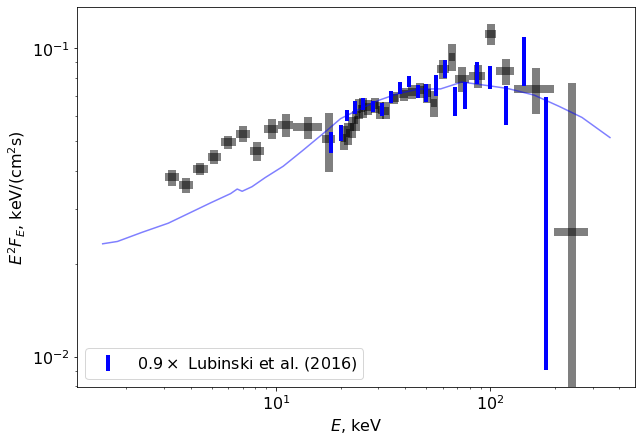

In [29]:
plt.figure(figsize=(10,7))

spectrum=np.genfromtxt(name+'_spectrum_osa10.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='black',alpha=0.5)
#plt.plot(en,mo,color='black',linewidth=4)


factor=0.9
d=np.genfromtxt('NGC2110_isgri_lubinski.csv')
en=d[:,0]
f=d[:,1]
fmax=d[:,2]
fmin=d[:,3]
plt.errorbar(en,factor*f,yerr=[factor*(f-fmin),factor*(fmax-f)],linestyle='none',linewidth=4,color='blue',label=r'$0.9\times$ Lubinski et al. (2016)')

d=np.genfromtxt('NGC2110_model_lubinski.csv')
en=d[:,0]
f=d[:,1]
plt.plot(en,factor*f,color='blue',alpha=0.5)



plt.tick_params(axis='both', which='major', labelsize=16)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1.e-1,3.e2)
#plt.xlim(3,500)
plt.legend(loc='lower left',fontsize=16)
plt.xlabel('$E$, keV',fontsize=16)
plt.ylabel('$E^2F_E$, keV/(cm$^2$s)',fontsize=16)
plt.savefig(name+'_spectra.pdf',format='pdf',dpi=100)


